<a href="https://colab.research.google.com/github/Satoru625/lightgbm_multiclass/blob/main/lightgbm_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv('student-por.csv', delimiter=";")

In [2]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [4]:
data = data.drop(columns=["G2", "G3"])

<Axes: >

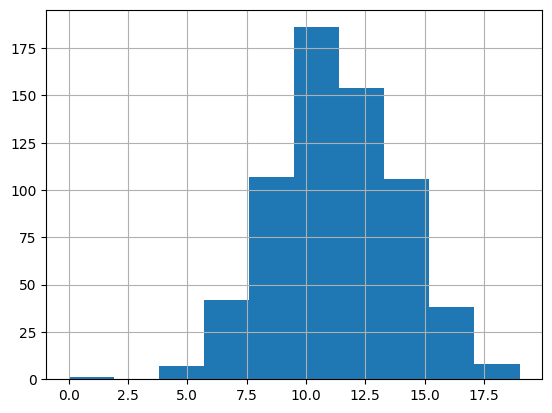

In [5]:
data["G1"].hist()

In [6]:
def categorize_g1(g1_score):
    if g1_score < 10:
        return "Low"
    elif g1_score >= 13:
        return "High"
    else:
        return "Mid"

data_cat = data.copy()
data_cat['G1'] = data_cat['G1'].apply(categorize_g1)

In [7]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import shap

In [8]:
X = data_cat.drop("G1", axis=1)
le = LabelEncoder()
y = le.fit_transform(data_cat["G1"]) # light
print(y)

[1 1 2 0 2 2 0 2 0 2 0 2 2 2 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 0
 0 2 0 2 2 0 1 2 2 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 2 0 0 0 0 2 2 2 0 0 2 0 0
 2 2 2 0 1 2 2 2 2 0 0 2 0 0 2 1 1 0 2 0 2 0 1 0 2 2 1 0 2 2 0 2 2 0 2 0 0
 2 1 0 2 0 0 0 2 0 0 0 0 2 2 1 2 1 0 0 2 2 2 2 0 0 1 0 2 0 2 0 2 2 2 1 2 0
 1 1 1 0 2 0 2 1 2 2 2 0 2 1 2 2 1 0 2 0 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 0 1
 0 2 0 0 2 0 2 2 2 2 2 0 0 0 2 2 0 2 1 2 2 2 2 0 0 0 2 0 2 0 2 0 0 0 1 2 0
 2 2 2 0 0 2 2 0 2 2 2 2 2 2 0 2 0 1 0 2 1 0 0 2 0 0 1 2 0 1 0 2 1 1 1 2 0
 2 2 0 1 1 2 0 0 0 2 0 0 2 0 2 2 2 0 2 1 1 2 2 1 1 1 0 2 1 2 0 2 2 2 2 2 2
 0 1 2 2 0 2 2 0 2 1 0 2 2 2 1 2 0 0 0 0 0 2 2 2 0 0 1 2 2 2 0 0 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 0 2 2 2 2 0 0 2 0 2 2 2 2 0 0 2 2 1 2
 1 2 0 2 0 0 0 0 0 2 0 0 2 2 2 2 0 0 2 2 0 2 2 0 0 2 0 2 2 0 0 0 2 2 2 2 2
 1 1 0 0 2 0 1 2 1 0 0 0 1 0 1 2 2 2 2 2 0 1 2 2 2 1 0 2 2 1 2 2 0 1 1 2 1
 1 1 2 1 0 2 0 2 1 2 1 1 0 2 0 2 2 0 0 0 2 1 2 0 0 0 0 2 0 2 2 2 2 2 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 

In [12]:
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = X[col].astype("category")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=cat_cols)

In [13]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'verbosity': -1
}

verbose_eval = 1 # 1にすると学習時のスコアを表示する
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval],
                  num_boost_round=100,
                  callbacks=[lgb.log_evaluation(verbose_eval),
                             lgb.early_stopping(stopping_rounds=10, verbose=True)]
                  )

[1]	training's multi_logloss: 1.01997	valid_1's multi_logloss: 1.05023
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 0.971239	valid_1's multi_logloss: 1.03222
[3]	training's multi_logloss: 0.928807	valid_1's multi_logloss: 1.01794
[4]	training's multi_logloss: 0.890343	valid_1's multi_logloss: 1.00711
[5]	training's multi_logloss: 0.859721	valid_1's multi_logloss: 0.998921
[6]	training's multi_logloss: 0.828058	valid_1's multi_logloss: 0.98653
[7]	training's multi_logloss: 0.80297	valid_1's multi_logloss: 0.97588
[8]	training's multi_logloss: 0.776559	valid_1's multi_logloss: 0.969815
[9]	training's multi_logloss: 0.753711	valid_1's multi_logloss: 0.965453
[10]	training's multi_logloss: 0.731798	valid_1's multi_logloss: 0.964813
[11]	training's multi_logloss: 0.712468	valid_1's multi_logloss: 0.963148
[12]	training's multi_logloss: 0.693212	valid_1's multi_logloss: 0.964902
[13]	training's multi_logloss: 0.674956	valid_1's multi_logloss: 0.9

In [14]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.48      0.44      0.46        45
           1       0.55      0.52      0.53        31
           2       0.46      0.50      0.48        54

    accuracy                           0.48       130
   macro avg       0.50      0.49      0.49       130
weighted avg       0.49      0.48      0.48       130



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

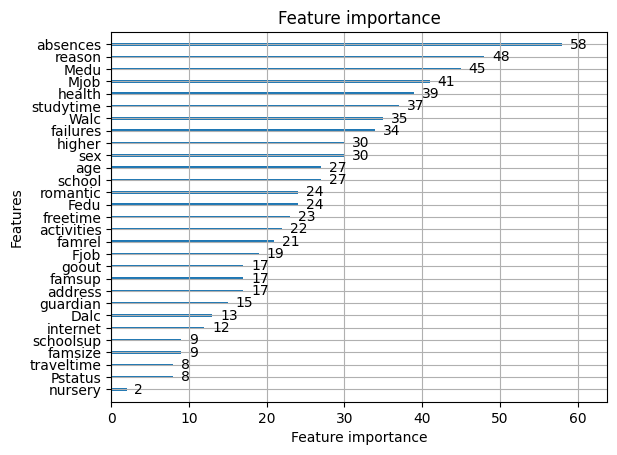

In [15]:
# Feature importance 1
lgb.plot_importance(model, importance_type="split")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

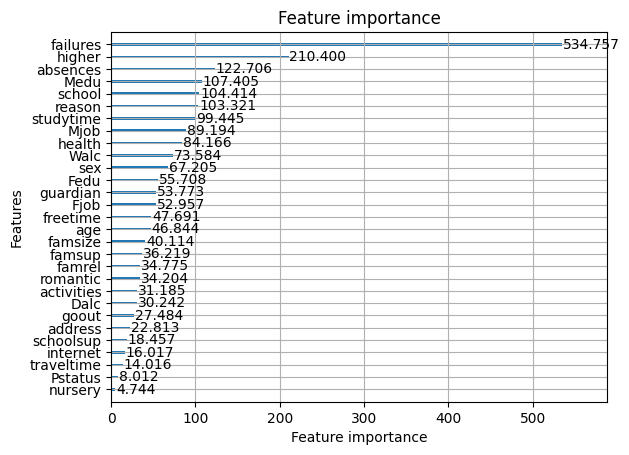

In [16]:
# Feature importance 2
lgb.plot_importance(model, importance_type="gain")

In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

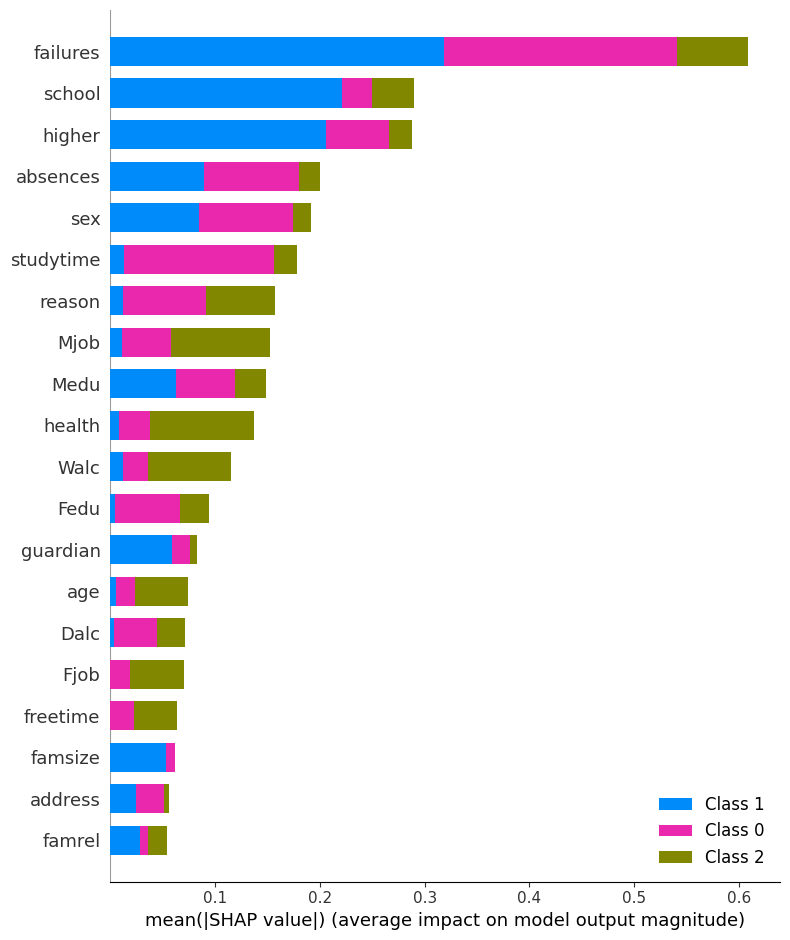

In [18]:
shap.summary_plot(shap_values)

In [19]:
shap_values[0,:,0]

.values =
array([ 0.00967053,  0.10979922, -0.11019492,  0.01038132, -0.01554029,
        0.        ,  0.12626673,  0.07606362, -0.12406213,  0.07438092,
       -0.04435411, -0.0048365 , -0.01978904, -0.09802896,  0.13262484,
       -0.03130972,  0.00827785,  0.        , -0.02203577,  0.0020605 ,
        0.03481148,  0.01044516,  0.0033654 ,  0.00478066,  0.00043448,
       -0.00346222,  0.02982295,  0.00782036, -0.0279382 , -0.1320573 ])

.base_values =
np.float64(-1.1364848827184115)

.data =
array(['GP', 'F', 18, 'U', 'GT3', 'A', 4, 4, 'at_home', 'teacher',
       'course', 'mother', 2, 2, 0, 'yes', 'no', 'no', 'no', 'yes', 'yes',
       'no', 'no', 4, 3, 4, 1, 1, 3, 4], dtype=object)

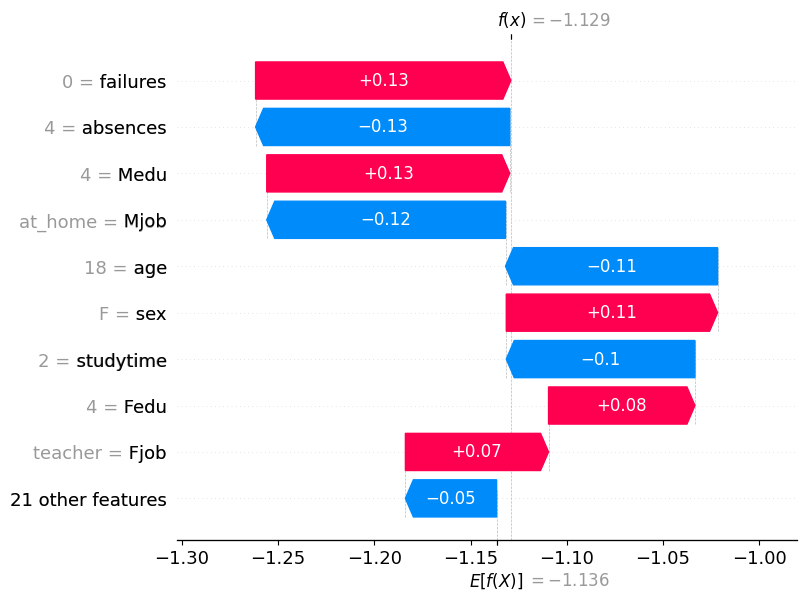

In [20]:
shap.waterfall_plot(shap_values[0,:,0])

In [21]:
shap.initjs()
shap.force_plot(shap_values[0,:,0])

In [22]:
shap.initjs()
shap.force_plot(shap_values[0:5,:,0])